## Problem: Detect credit card transaction fraud

Dataset from: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, average_precision_score
from sklearn.model_selection import KFold

from imblearn import over_sampling

import math
from scipy import stats

In [3]:
# Load dataset
cc_fraud = pd.read_csv("creditcard.csv")
cc_fraud.shape

(284807, 31)

In [4]:
print(f'Total positive classes: {sum(cc_fraud.Class==1)} out of {cc_fraud.Class.count()}.')

Total positive classes: 492 out of 284807.


c:\her_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


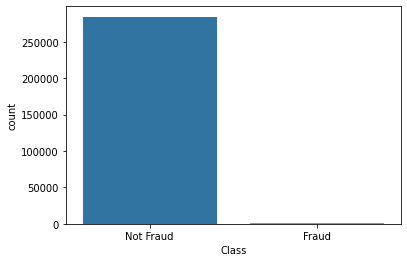

In [5]:
# Visualizing class
cls = sns.countplot(cc_fraud.Class)
cls.set_xticklabels(['Not Fraud', 'Fraud'])
plt.show()

In [6]:
cc_ = cc_fraud.copy()

cc_['Hour'] = cc_['Time'].apply(lambda x: np.ceil(x / 3600) % 24)


tmp = cc_.groupby(['Hour', 'Class'])['Amount'].aggregate(['count']).reset_index()
transactions = pd.DataFrame(tmp)
transactions.columns = ['Hour', 'Class', 'Transactions']
transactions

,Hour,Class,Transactions
0,0.0,0,10919
1,0.0,1,21
2,1.0,0,7687
3,1.0,1,6
4,2.0,0,4212
5,2.0,1,10
6,3.0,0,3269
7,3.0,1,57
8,4.0,0,3476
9,4.0,1,17


c:\her_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


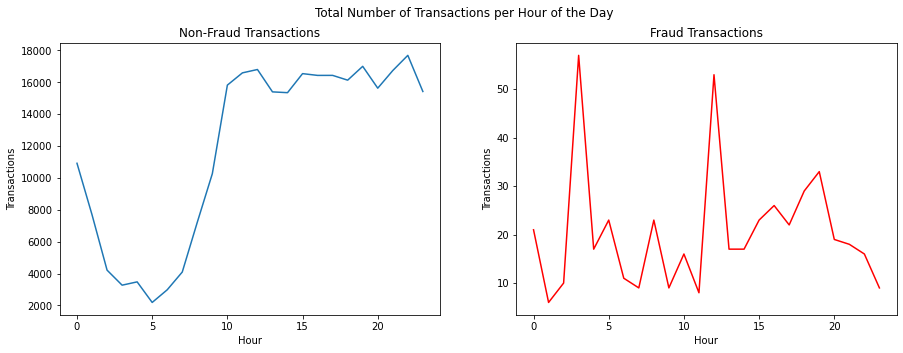

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.lineplot(x='Hour', y='Transactions', data=transactions.query('Class == 0'), ax=ax[0])
sns.lineplot(x='Hour', y='Transactions', data=transactions.query('Class == 1'), color='red', ax=ax[1])
fig.suptitle('Total Number of Transactions per Hour of the Day')
ax[0].set(title='Non-Fraud Transactions')
ax[1].set(title='Fraud Transactions')
fig.show()

- In the above right graph, we can see that the majority of the frauds happen at specific times (where the red graph peaks ~3:30 and ~12:30.
- In a real world scenario, we could automate our model to be more strict during these peak hours.

## EDA

In [9]:
cc_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- We see the "Amount" field has some possible outliers (if we compare the max and the mean)

In [10]:
# See if there are any NaN values
cc_fraud.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [12]:
# Check for duplicates
print(f'Total duplicates: {cc_fraud.duplicated().sum()}')
cc_fraud.drop_duplicates(inplace=True)
print(f'Total positive classes after removal: {sum(cc_fraud.Class==1)} out of {cc_fraud.Class.count()}')

Total duplicates: 0
Total positive classes after removal: 473 out of 283726


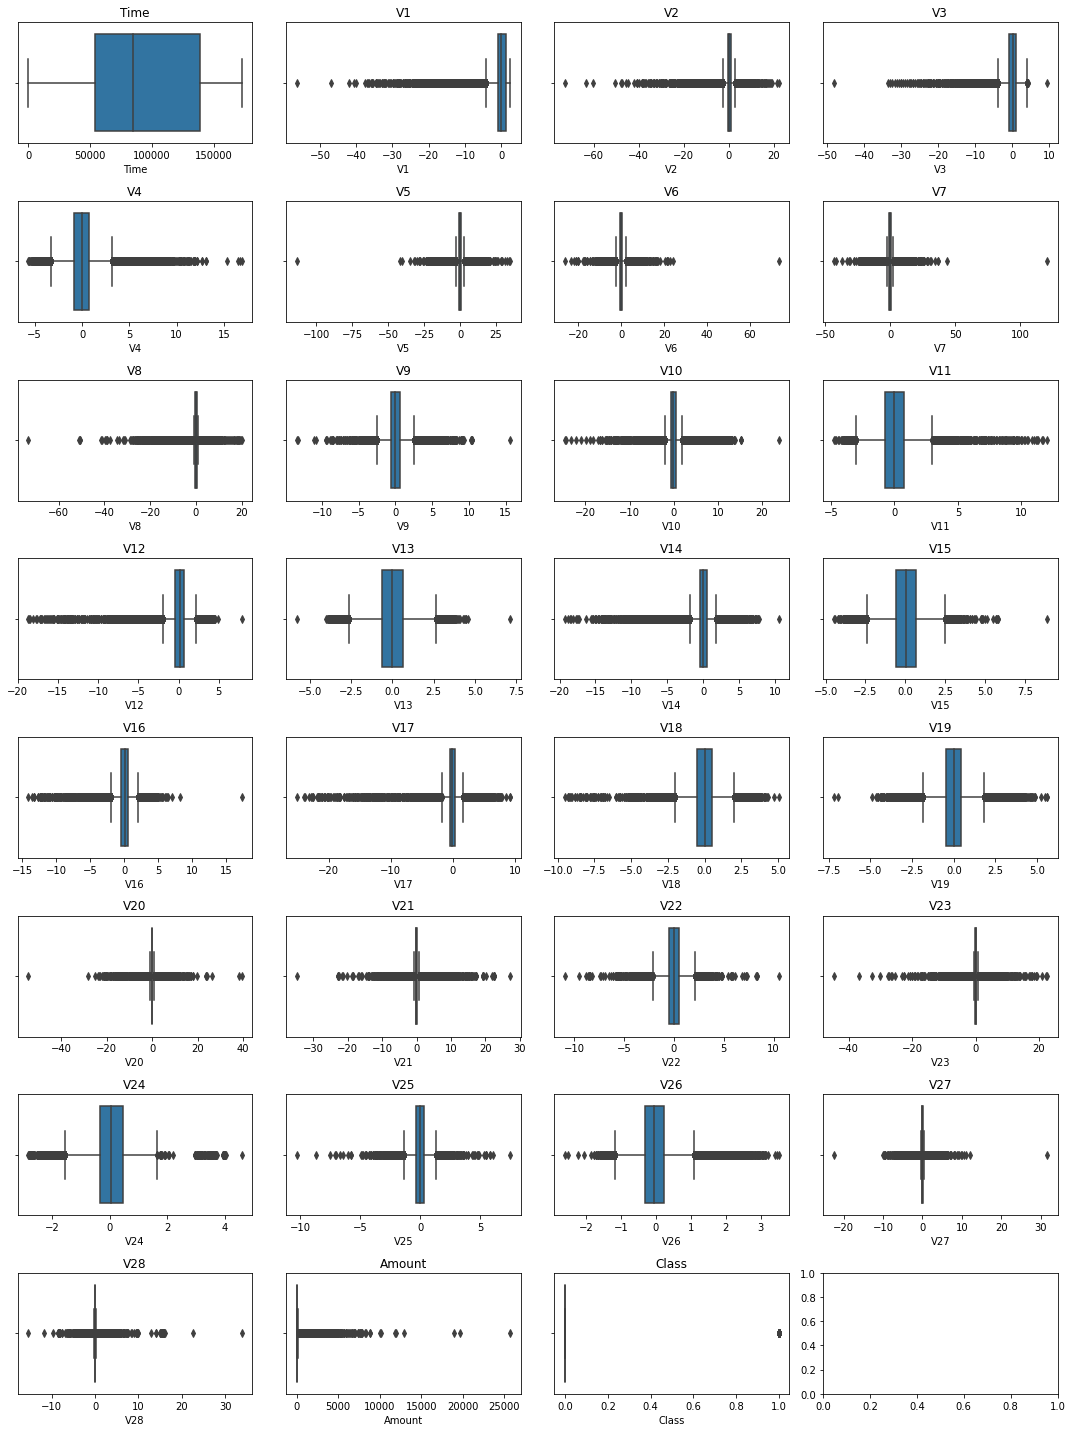

In [13]:
# Plot outliers
cols = cc_fraud.columns
rows = math.ceil(cc_fraud.shape[1]/4)
# create the figure and axes
fig, axes = plt.subplots(rows, 4, figsize=(15, 20))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.boxplot(x=col, data=cc_fraud, ax=ax)
    ax.set_title(col)
fig.tight_layout()
plt.show()

- We can see that in the description table it wasn't very obvious which columns had outliers, but we notice with the boxplots that almost all of the fields have many outliers

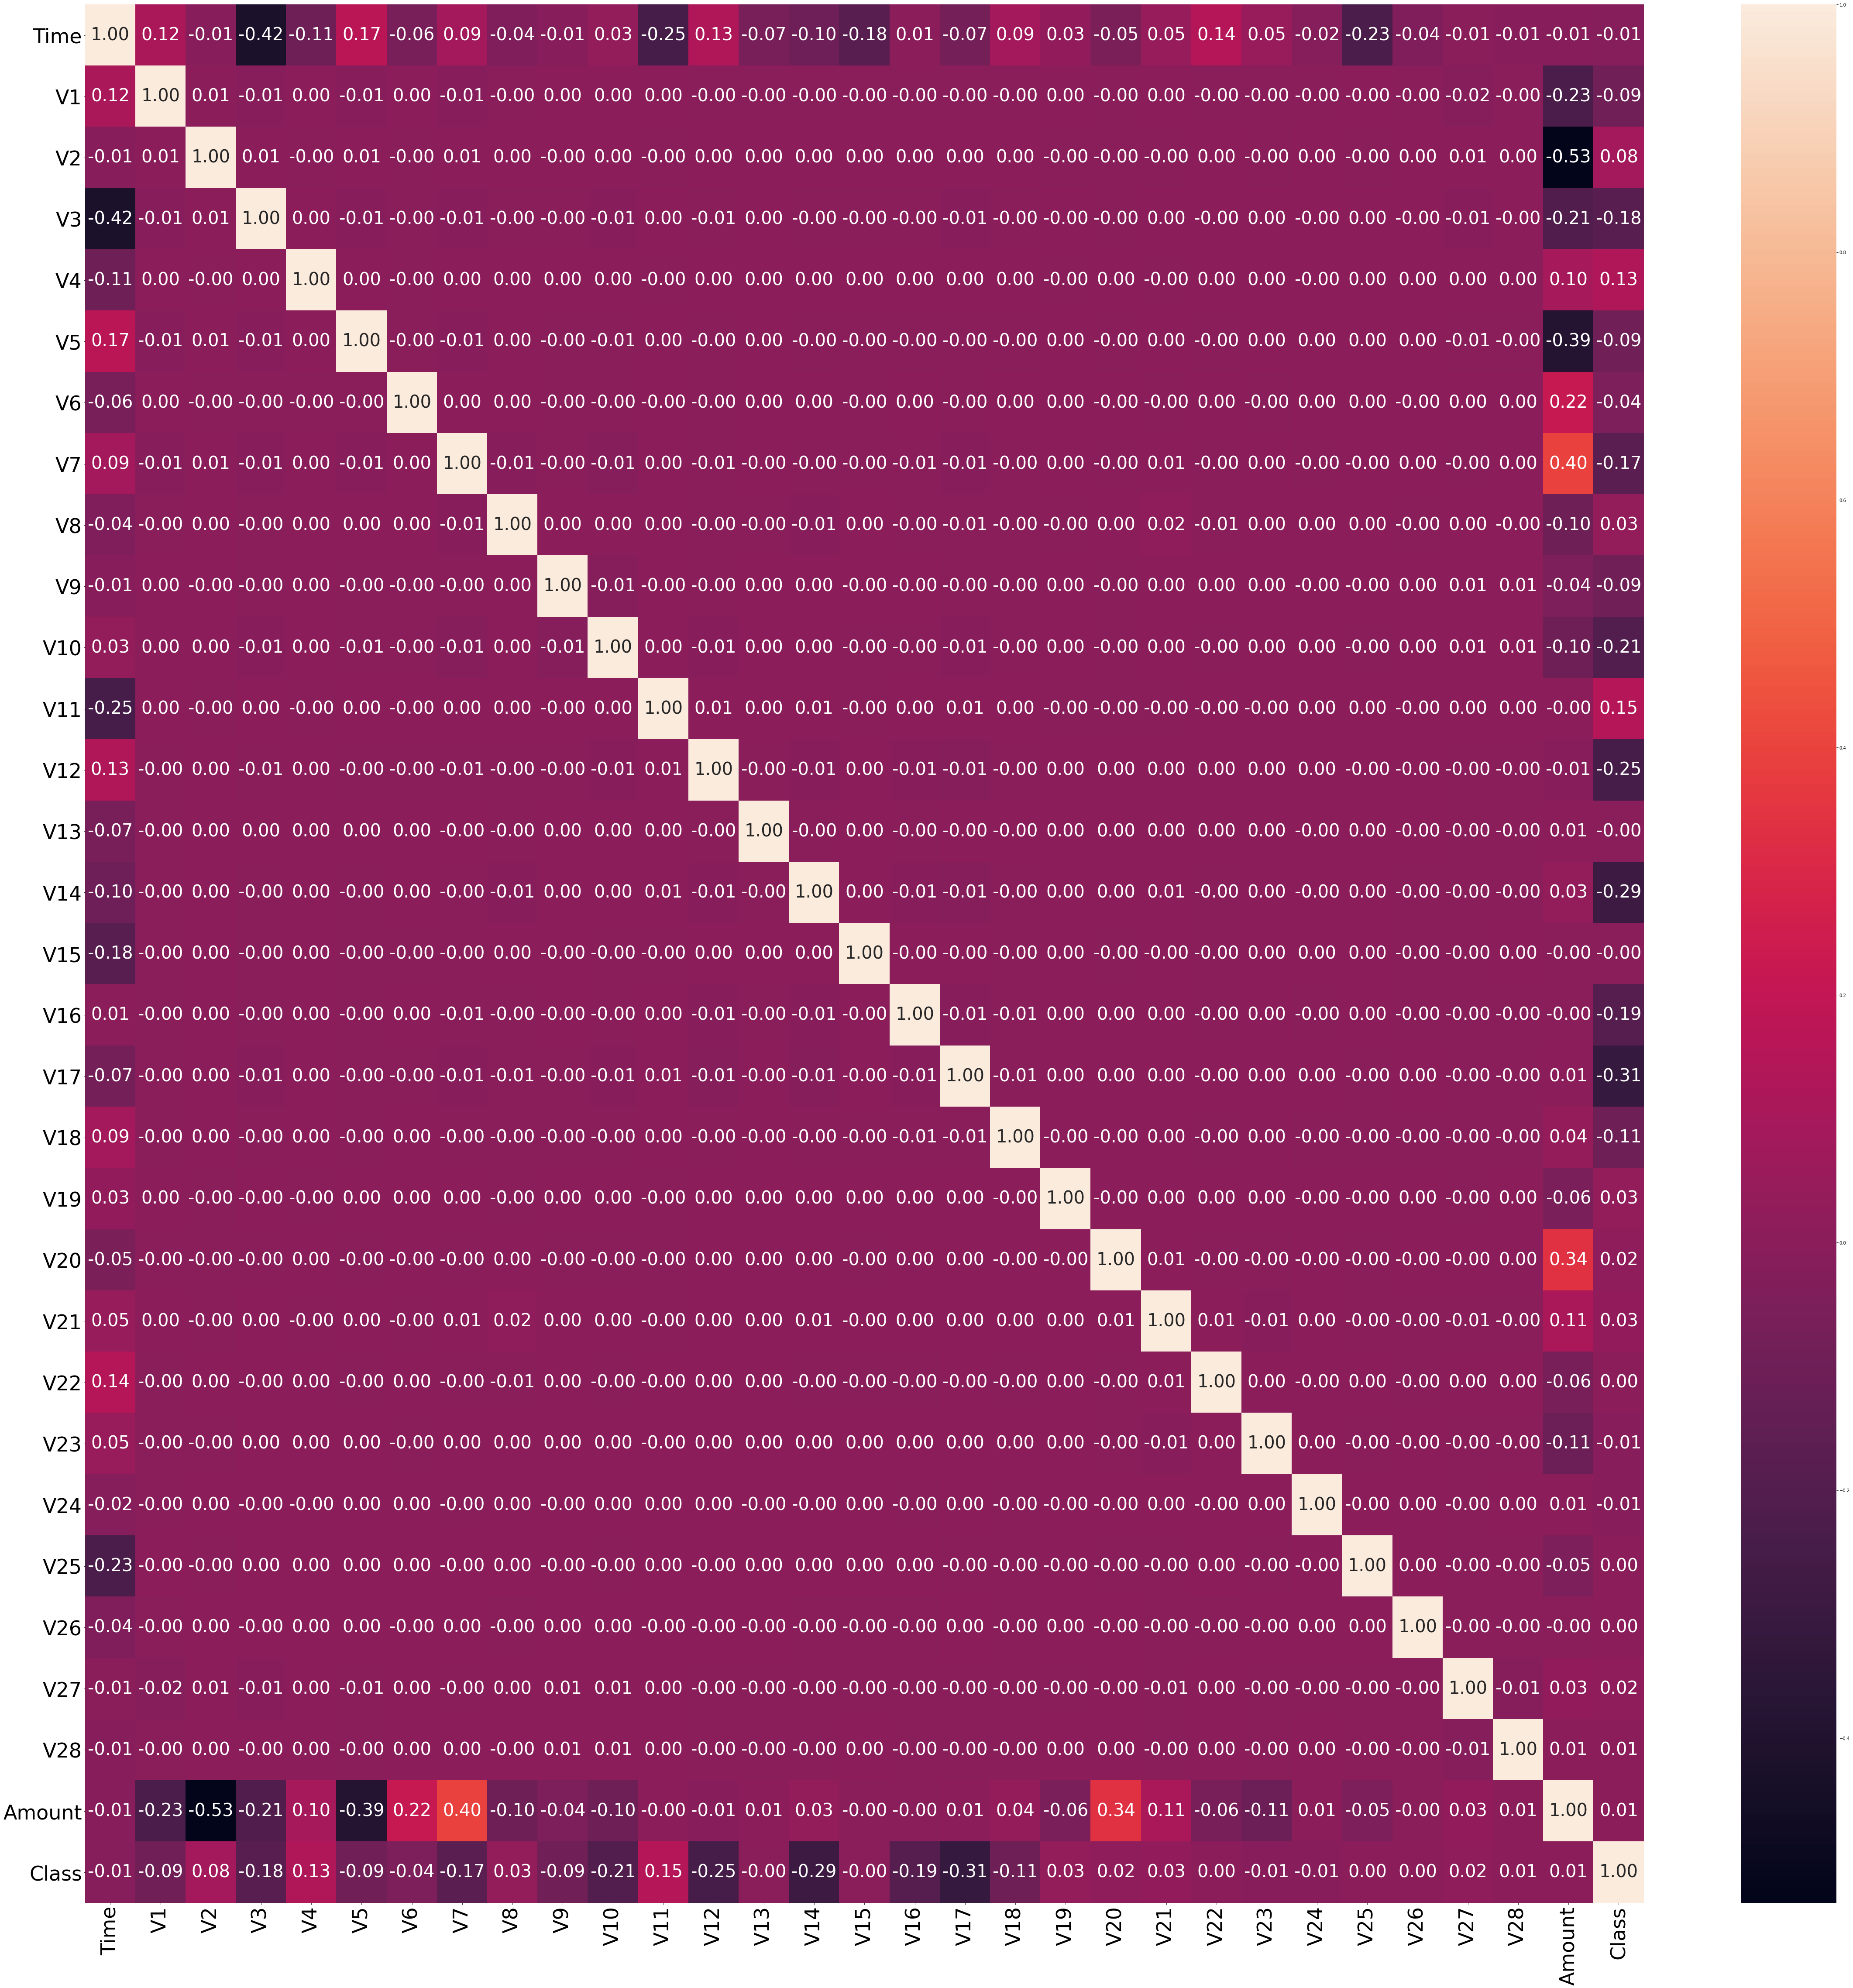

In [14]:
# Calculate correlations
corr = cc_fraud.corr()
fig, ax = plt.subplots(figsize=(80,80))
plt.xticks(fontsize=46)
plt.yticks(fontsize=46)
sns.heatmap(corr, annot=True, annot_kws = {'size':40}, fmt='.2f') #fmt = '.2f' is to round the values (2 decimal places)
plt.show()

- From the correlation matrix, the only significant insight we get is that "V6" and "V20" is somehow positive correlated to the amount of the transaction.
- In addition, we see that "V2" and "V5" is negative correlated to the amount of the transaction.
- Furthermore, we can already see some attributes that have a high correlation negatively with the "Class" (V7, V10, V14, V17 etc.).

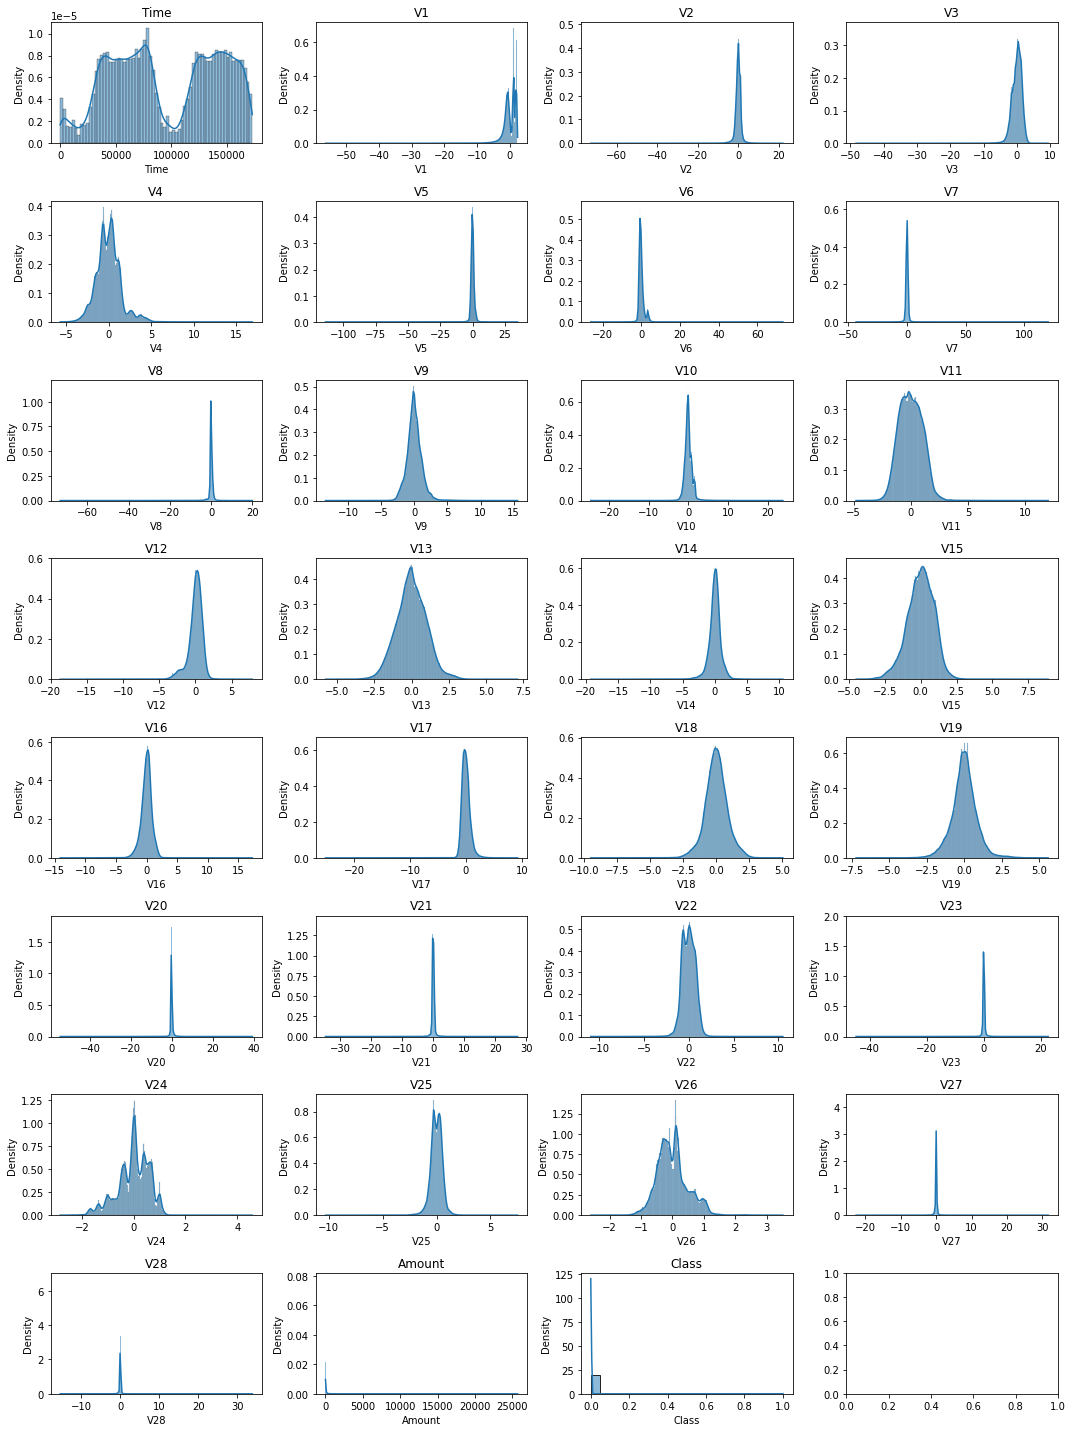

In [14]:
# select the columns to be plotted
cols = cc_fraud.columns

# create the figure and axes
fig, axes = plt.subplots(rows, 4, figsize=(15, 20))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(data=cc_fraud[col], kde=True, stat='density', ax=ax)
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Data processing and Feature Engineering

In [15]:
# Clip the outliers
cc_fraud_f = cc_fraud.copy()
for col in cc_fraud.columns[1:-1]:
    Q1 = cc_fraud[col].quantile(0.25)
    Q3 = cc_fraud[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cc_fraud_f[col] = cc_fraud[col].clip(lower_bound, upper_bound)

## Z score removal (worse performance)
# z = np.abs(stats.zscore(cc_fraud_f.drop(columns={"Class"})))
# threshold = 3
# cc_fraud_f = cc_fraud_f[(z < 2).all(axis=1)]

In [16]:
print(cc_fraud.shape)
print(cc_fraud_f.shape)

(283726, 31)
(283726, 31)


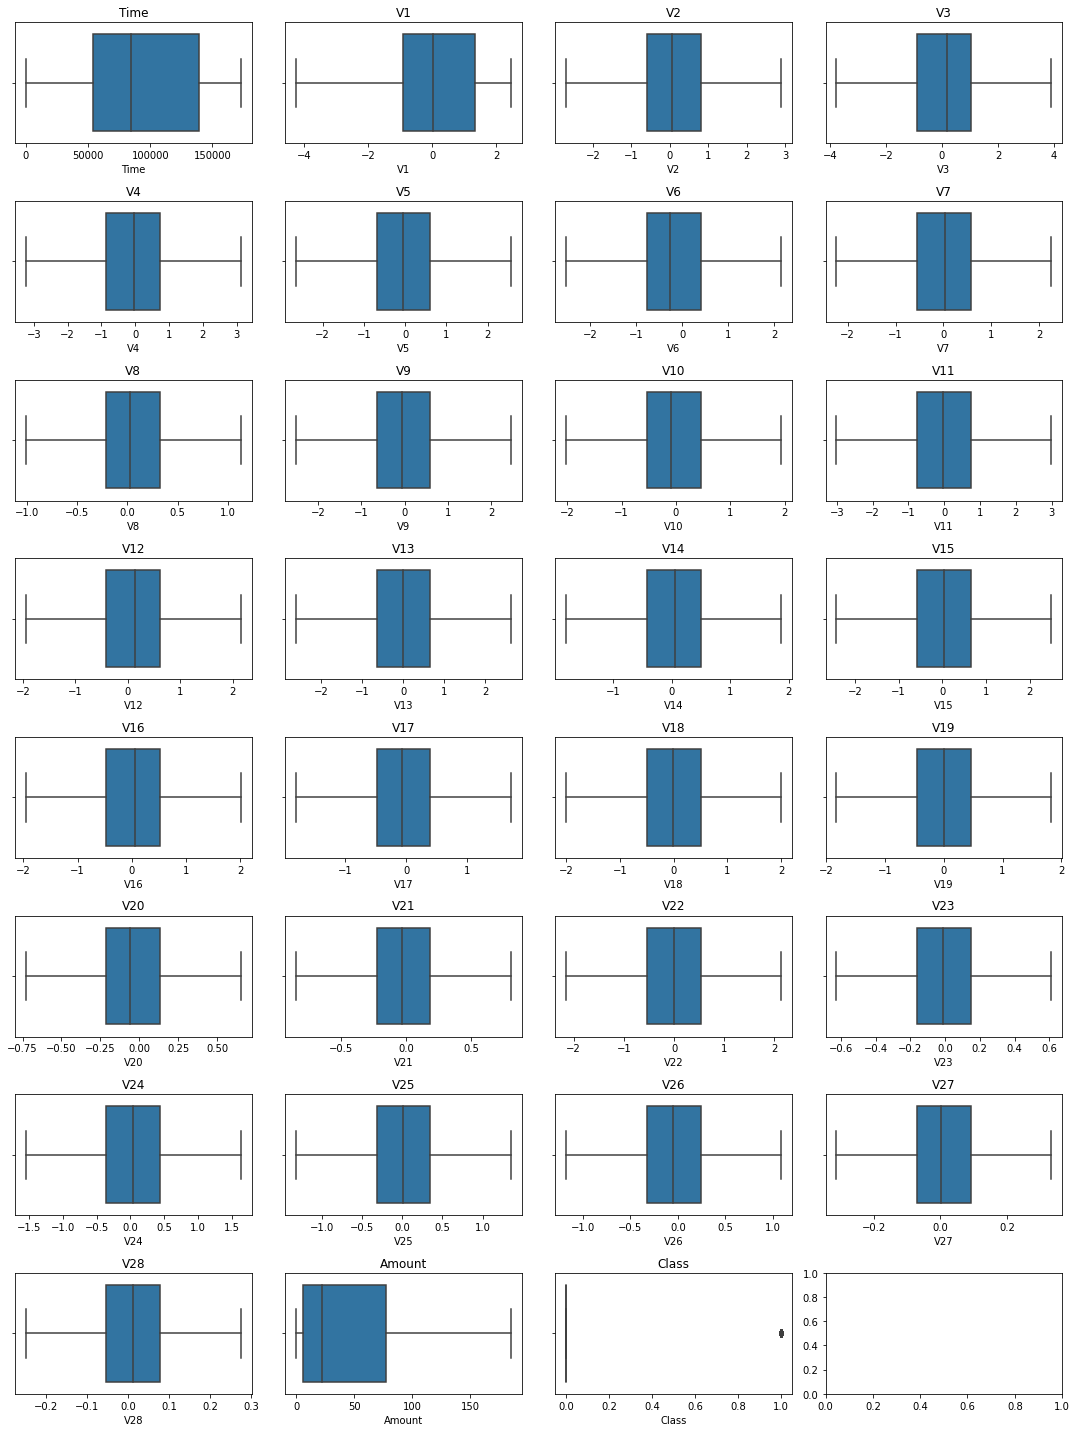

In [17]:
# Plot outliers
cols = cc_fraud_f.columns

# create the figure and axes
fig, axes = plt.subplots(rows, 4, figsize=(15, 20))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.boxplot(x=col, data=cc_fraud_f, ax=ax)
    ax.set_title(col)
fig.tight_layout()
plt.show()

- We can already see that the outliers left.

## Dealing with class imbalance

- The approach I used is the "SMOTE" method.

In [18]:
# Value counts before SMOTE
cc_fraud_f.Class.value_counts()

0    283253
1       473
Name: Class, dtype: int64

In [19]:
features = list(cc_fraud.columns[:-1])
x = cc_fraud_f[features]
y = cc_fraud_f.Class
features

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [20]:
smote = over_sampling.SMOTE()

In [21]:
# Fit data for balancing
x_smote, y_smote = smote.fit_resample(x, y)

# to numpy
x = x_smote.to_numpy()
y = y_smote.to_numpy()

In [22]:
# Value counts after SMOTE
y_smote.to_frame().value_counts()

Class
1        283253
0        283253
dtype: int64

In [23]:
scaler = StandardScaler()
scaler.fit(x)

StandardScaler()

In [24]:
clf = linear_model.LogisticRegression(max_iter=1000)

In [25]:
# KFold training
N_FOLDS = 10
kf = KFold(N_FOLDS, shuffle=True, random_state=1)
feature_importance = []
scores_val = pd.DataFrame()

for fold_, (trn_idx, tst_idx) in enumerate(kf.split(x)):
    print(f"Fold: {fold_+1}/{N_FOLDS}")
    x_train, x_test = scaler.transform(x[trn_idx]), scaler.transform(x[tst_idx])
    y_train, y_test = y[trn_idx], y[tst_idx]
    clf.fit(x_train,y_train)
    
    # Scores
    y_pred = clf.predict(x_test)
    x_test_scores = clf.decision_function(x_test)

    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'F1: {f1_score(y_test, y_pred)}')
    print(f'Average Precision (AUPRC): {average_precision_score(y_test, x_test_scores)}')
    print('----------------------------------------------')
    
    scores_temp = {}
    scores_temp["accuracy"] = accuracy_score(y_test, y_pred)
    scores_temp["recall"] = recall_score(y_test, y_pred)
    scores_temp["precision"] = precision_score(y_test, y_pred)
    scores_temp["f1"] = f1_score(y_test, y_pred)
    scores_temp["auprc"] = average_precision_score(y_test, x_test_scores)

    scores_val = pd.concat([scores_val, pd.DataFrame(data=scores_temp, index=[fold_])], axis=0)
    
    feature_importance.append(clf.coef_[0])
    
scores_val

Fold: 1/10
Accuracy: 0.973786870487723
Recall: 0.9622321838269033
Precision: 0.9850050585344703
F1: 0.973485457174996
Average Precision (AUPRC): 0.9960087276820491
----------------------------------------------
Fold: 2/10
Accuracy: 0.9741399092690332
Recall: 0.9619918125352908
Precision: 0.98596592758708
F1: 0.9738313416572889
Average Precision (AUPRC): 0.9965495381627816
----------------------------------------------
Fold: 3/10
Accuracy: 0.9728689696563168
Recall: 0.9588606479359819
Precision: 0.9865796155241204
F1: 0.9725226594204194
Average Precision (AUPRC): 0.9961579604446495
----------------------------------------------
Fold: 4/10
Accuracy: 0.9748812907097845
Recall: 0.9627342343931962
Precision: 0.9867259837962963
F1: 0.9745824774493168
Average Precision (AUPRC): 0.9958571038917451
----------------------------------------------
Fold: 5/10
Accuracy: 0.9748812907097845
Recall: 0.963262852697829
Precision: 0.9861005538060593
F1: 0.9745479260941887
Average Precision (AUPRC): 0.9962

,accuracy,recall,precision,f1,auprc
0,0.973787,0.962232,0.985005,0.973485,0.996009
1,0.974140,0.961992,0.985966,0.973831,0.996550
2,0.972869,0.958861,0.986580,0.972523,0.996158
3,0.974881,0.962734,0.986726,0.974582,0.995857
4,0.974881,0.963263,0.986101,0.974548,0.996291
5,0.973857,0.960997,0.986234,0.973452,0.996412
6,0.973698,0.961910,0.984694,0.973169,0.996213
7,0.973857,0.960961,0.986651,0.973637,0.996431
8,0.974069,0.963056,0.984873,0.973842,0.996171
9,0.973610,0.961904,0.985108,0.973368,0.996208


In [26]:
print("Average score from k-fold")
scores_val.mean()

Average score from k-fold


accuracy     0.973965
recall       0.961791
precision    0.985794
f1           0.973644
auprc        0.996230
dtype: float64

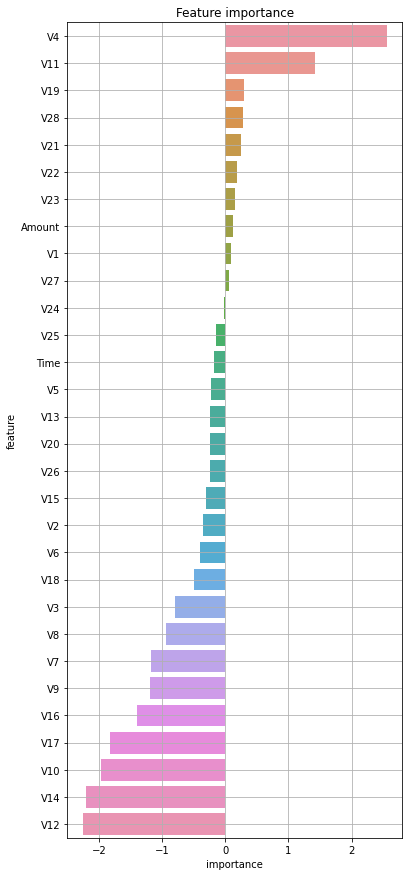

In [27]:
# Visualizing feature importance "fi"

fi = pd.DataFrame(data=feature_importance, columns=features)
fi_ = pd.DataFrame(data={"feature": features,"importance" : list(fi.mean())})

importance_sorted = fi_.sort_values(by="importance", ascending=False)

plt.figure(figsize = (6, 15))
sns.barplot(x="importance", y="feature", data=importance_sorted)
plt.title('Feature importance')
plt.grid(True)
plt.show()

- Unfortunately, since our features are PCA transformed, we don't know what they are. If we've known, the above graph would be very insightful.
- The only features we know are "Time" and "Amount", and in both cases we see that the correlation for fraud is very neutral, with "Time" being slightly negative correlated and and "Amount" slightly positevely correlated.

### Conclusions

- The main component that improved the Logistic regression model significantly was the SMOTE balancing approach.
- Clipping the outliers didn't improve the model significantly.
- The overall scores indicate that the model performs quite good.

### Future work

- Use a boosting classifier for better performance